In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from recurrent_attention import RecurrentAttention

## Overhead stuff

Helper functions for batching, resetting hidden states, etc.

In [2]:
# Data gen parameters
num_batches = 500
num_eval_batches = 20
ntokens = 7
dep_len = 6

# Training hyperparameters
eval_batch_size = 20
batch_size = 50
seq_len = 11
dropout = 0.1
clip = 1
lr = 0.05
warmup_steps = 5
decay_factor = 0.5  # Higher => faster learning rate decay
smoothing = 0.001

epochs = 50
log_interval = 100   # Print log every `log_interval` batches

In [3]:
# Model hyperparameters
embed_size = 64
encode_size = 32
h_size = 16
decode_size = 64
n_enc_layers = 1
n_dec_layers = 1
smooth_align = True

bidirectional_attn = False

## Generate data

In [4]:
# Generate some token transition probabilities
probs = np.random.randint(1, 10*ntokens, size = tuple(ntokens for _ in range(dep_len+1)))
# Normalize
probs = probs / (probs.sum(axis = -1)[..., np.newaxis])
probs.shape

(7, 7, 7, 7, 7, 7, 7)

In [5]:
def gen_data(num_batches, batch_size, seq_len):
    num_data = num_batches * batch_size * seq_len
    # Initialize numpy array for the generated data
    data = np.zeros((num_data,), dtype = int)
    # Randomly generate a series of starting tokens
    ts = [np.random.randint(ntokens, size = 1) for _ in range(dep_len)]
    # Generate the data
    for i in range(num_data):
        pr = probs[ts].squeeze()
        data[i] = np.random.choice(ntokens, p = pr)
        ts.pop(0)
        ts.append(data[i].reshape(1,1))
    return torch.from_numpy(data).type(torch.LongTensor)

### Helper functions

In [6]:
# Starting from sequential data, `batchify` arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into batches
    nbatches = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data.narrow(0, 0, nbatches * batch_size)
    # Evenly divide the data across the batches
    data = data.view(batch_size, -1).t().contiguous()
    return data  # [seq_len, batch_size]

# Wraps hidden states into new Variables to detach them from their history
def repackage_hidden(h):
    if type(h) == Variable:
        return Variable(h.data)
    else:
        return tuple(repackage_hidden(v) for v in h)
    
# `get_batch` subdivides the source data into chunks of the specified length.
# E.g., using the example for the `batchify` function above and a length of 2,
# we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the `batchify` function. The chunks are along dimension 0, corresponding
# to the `seq_len` dimension in the LSTM.
def get_batch(source, i, seq_len, evaluate = False):
    seq_len = min(seq_len, len(source) - 1 - i)
    data = Variable(source[i : i+seq_len], volatile = evaluate)
    target = Variable(source[i+1 : i+1+seq_len].view(-1), volatile = evaluate)
    return data, target

In [7]:
train_data = batchify(gen_data(num_batches, batch_size, seq_len), batch_size)
val_data = batchify(gen_data(num_eval_batches, batch_size, seq_len), eval_batch_size)
test_data = batchify(gen_data(num_eval_batches, batch_size, seq_len), eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([5500, 50]), torch.Size([550, 20]), torch.Size([550, 20]))

Label smoothing class for regularization.

In [8]:
class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx = None, smoothing = 0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss()
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = torch.zeros_like(x.data)
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist.add_(self.smoothing / self.size)
        if self.padding_idx is not None:
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad = False)) * ntokens

Learning rate scheduler that sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

In [9]:
def get_lr_scheduler(h_size, warmup, optimizer):
    lrate = lambda e: h_size**(-0.5) * min((e+1)**(-decay_factor), (e+1) * warmup**(-(decay_factor+1)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lrate)

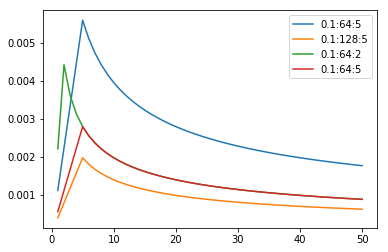

In [10]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.1f:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.1f:%d:%d" % (lr, embed_size, warmup_steps),
])

## Model class

In [11]:
class RNNModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, embed_size, encode_size, h_size,
                 decode_size, n_enc_layers, n_dec_layers, align_location = False,
                 loc_align_size = 1, loc_align_kernel = 1, smooth_align = False,
                 bidirectional_attn = False, tie_wts = True, dropout = 0.1):
        super(RNNModel, self).__init__()
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.embed_size = embed_size
        self.encode_size = encode_size
        self.h_size = h_size
        self.decode_size = decode_size
        self.n_enc_layers = n_enc_layers
        self.n_dec_layers = n_dec_layers
        self.align_location = align_location
        self.loc_align_size = loc_align_size
        self.loc_align_kernel = loc_align_kernel
        self.smooth_align = smooth_align
        self.bidirectional_attn = bidirectional_attn
        self.tie_wts = tie_wts
        self.dropout = dropout
        
        self.drop = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.embedding = nn.Embedding(src_vocab, embed_size)
        self.encoders = nn.ModuleList([
            nn.LSTM(
                input_size = embed_size if i == 0 else encode_size,
                hidden_size = encode_size, dropout = dropout
            ) for i in range(n_enc_layers)
        ])
        self.attn = RecurrentAttention(
            in_size = encode_size, h_size = h_size, out_size = decode_size,
            align_location = align_location, loc_align_size = loc_align_size,
            loc_align_kernel = loc_align_kernel, smooth_align = smooth_align,
            num_rnn_layers = n_dec_layers, attn_act_fn = 'ReLU',
            dropout = dropout, bidirectional = bidirectional_attn
        )
        self.projection = nn.Linear(decode_size, tgt_vocab)
        if tie_wts and src_vocab == tgt_vocab and embed_size == decode_size:
            self.embedding.weight = self.projection.weight
        self.log_softmax = nn.LogSoftmax(dim = -1)
            
        # For visualizations
        self.save_wts = False
        self.enc_out = None
        self.dec_out = None
        
    def init(self):
        for layer in self.encoders:
            for p in layer.parameters():
                if p.dim() > 1:
                    nn.init.xavier_normal(p)
                else:
                    p.data.fill_(0)
        for p in self.projection.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform(p)
            else:
                p.data.fill_(0)
        self.attn.init()
        
    def init_states(self, batch_size):
        encoder_states = [
            (
                Variable(torch.zeros(1, batch_size, self.encode_size)),
                Variable(torch.zeros(1, batch_size, self.encode_size))
            ) for _ in range(self.n_enc_layers)
        ]
        attn_states = self.attn.init_rnn_states(batch_size)
        return encoder_states, attn_states
    
    def forward(self, inputs, states):
        enc_states, attn_states = states
        if self.save_wts:
            self.enc_out = []
        
        embeddings = self.embedding(inputs) * np.sqrt(self.embed_size)
        
        new_enc_states = []
        enc_in = self.drop(self.relu(embeddings))
        for states, encoder in zip(enc_states, self.encoders):
            enc_out, new_enc_state = encoder(enc_in, states)
            new_enc_states.append(new_enc_state)
            if self.save_wts:
                self.enc_out.append(enc_out.data.clone())
            enc_in = enc_out
                
        attn_out, new_attn_states = self.attn(enc_out, attn_states)
        
        logits = self.projection(attn_out)
        output = self.log_softmax(logits)
        
        return output, (new_enc_states, new_attn_states)
    
    def train(self, mode = True, save_wts = False):
        super(RNNModel, self).train(mode)
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts
        
    def eval(self, save_wts = True):
        super(RNNModel, self).eval()
        self.attn.save_attn_wts = save_wts
        self.save_wts = save_wts

## Initialize model, criterion, optimizer, and learning rate scheduler

In [12]:
model = RNNModel(
    ntokens, ntokens, embed_size, encode_size,
    h_size, decode_size, n_enc_layers, n_dec_layers,
    dropout = dropout, smooth_align = smooth_align
)
model.init()
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 27576


## Train

Define training and validation loops

In [13]:
def train():
    # Use random length sequences
    seq_lens = []
    tot_len = 0
    jitter = 0.15 * seq_len
    num_data = train_data.size(0)
    while tot_len < num_data - 2:
        if num_data - tot_len - 2 <= seq_len + jitter:
            slen = num_data - tot_len - 2
        else:
            slen = int(np.random.normal(seq_len, jitter))
            if slen <= 0:
                slen = seq_len    # eh
            if tot_len + slen >= num_data - jitter - 2:
                slen = num_data - tot_len - 2
        seq_lens.append(slen)
        tot_len += slen
    i_cumseq = [0] + list(np.cumsum(seq_lens)[:-1])
    idx = np.arange(len(seq_lens))
    np.random.shuffle(idx)
    # Turn on training mode
    model.train(save_wts = False)
    # Initialize RNN states
    states = model.init_states(batch_size)
    # Prep metainfo
    total_loss = 0
    total_epoch_loss = 0
    start_time = time.time()
    for batch, i in enumerate(idx):
        # Get training data
        data, targets = get_batch(train_data, i_cumseq[i], seq_lens[i])
        # Repackage the hidden states
        states = model.init_states(batch_size)  #repackage_hidden(states)
        # Zero out gradients
        model.zero_grad()
        
        # Run the model forward
        output, _states = model(data, states)
        if np.isnan(output.data).any():
            return 0, total_epoch_loss[0], data, targets, states, _states
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        if np.isnan(loss.data[0]):
            return 1, total_epoch_loss[0], data, targets, states, _states
        states = _states
        # Propagate loss gradient backwards
        loss.backward()
        # Clip gradients
        if batch % log_interval == 0 and batch > 0:
            # Save gradient statistics before they're changed cuz we'll be logging this batch
            parameters = [p for p in model.parameters() if p.grad is not None]
            # Calculate the largest (absolute) gradient of all elements in the model parameters
            max_grad = max([p.grad.data.abs().max() for p in parameters])
        total_norm = nn.utils.clip_grad_norm(model.parameters(), clip)
        # Scale the batch learning rate so that shorter sequences aren't "stronger"
        scaled_lr = lr_scheduler.get_lr()[0] * np.sqrt(seq_lens[i] / seq_len)
        for param_group in optimizer.param_groups:
            param_group['lr'] = scaled_lr
        # Update parameters
        optimizer.step()
        
        # Get some metainfo
        total_loss += loss.data
        total_epoch_loss += loss.data * data.size(0)
        if batch % log_interval == 0 and batch > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss[0] / log_interval
            print(' b {:3d}/{:3d} >> {:6.1f} ms/b | lr: {:8.2g} | grad norm: {:4.2f} | max abs grad: {:7.3f} | loss: {:4.2f} | perp.: {:6.2f}'.format(
                batch, len(seq_lens), elapsed * 1000/log_interval, scaled_lr, total_norm, max_grad, cur_loss, np.exp(cur_loss)
            ))
            total_loss = 0
            start_time = time.time()
    return -1, total_epoch_loss[0] / num_data, None, None, None, None

In [14]:
def evaluate(data_src, save_wts = True):
    model.eval(save_wts = save_wts)
    total_loss = 0
    states = model.init_states(eval_batch_size)
    for i in range(0, data_src.size(0) - 1, seq_len):
        # Get data
        data, targets = get_batch(data_src, i, seq_len, evaluate = True)
        # Repackage the hidden states
        states = model.init_states(eval_batch_size)  #repackage_hidden(states)
        # Evaluate
        output, states = model(data, states)
        # Calculate loss
        loss = criterion(output.view(-1, ntokens), targets)
        total_loss += loss.data * data.size(0)
    return total_loss[0] / data_src.size(0)

Train and evaluate

In [15]:
WIDTH = 112
CAUSES = ['output', 'grad']
for epoch in range(epochs):
    lr_scheduler.step()
    print('Epoch {:3d}/{:3d}) lr = {:0.4g}{}'.format(epoch+1, epochs, np.mean(lr_scheduler.get_lr()[0]), ' (warmup)' if epoch < warmup_steps else ''))
    start_time = time.time()
    stat, train_loss, data, targets, states, nstates = train()
    if stat in list(range(len(CAUSES))):
        c = CAUSES[stat]
        n = (WIDTH - len(c) - 4) // 2
        print('\n' + (' '*n) + 'NaN ' + c)
        break
    elapsed = time.time() - start_time
    val_loss = evaluate(val_data, save_wts = False)
    max_param = max([p.data.abs().max() for p in model.parameters() if p.grad is not None])
    print('-' * WIDTH)
    print('Elapsed time: {:6.2f} sec | train_loss: {:5.2f} | train_perp: {:6.2f} | valid_loss: {:5.2f} | valid_perp.: {:6.2f}'.format(
        elapsed, train_loss, np.exp(train_loss), val_loss, np.exp(val_loss)
    ))
    print('=' * WIDTH)
    print('\n')

Epoch   1/ 50) lr = 0.000559 (warmup)
 b 100/525 >>   21.1 ms/b | lr:  0.00041 | grad norm: 0.33 | max abs grad:   0.037 | loss: 1.88 | perp.:   6.55
 b 200/525 >>   19.7 ms/b | lr:  0.00056 | grad norm: 0.32 | max abs grad:   0.030 | loss: 1.77 | perp.:   5.85
 b 300/525 >>   19.8 ms/b | lr:  0.00056 | grad norm: 0.28 | max abs grad:   0.028 | loss: 1.73 | perp.:   5.66
 b 400/525 >>   19.6 ms/b | lr:  0.00058 | grad norm: 0.29 | max abs grad:   0.022 | loss: 1.71 | perp.:   5.52
 b 500/525 >>   22.1 ms/b | lr:  0.00058 | grad norm: 0.38 | max abs grad:   0.033 | loss: 1.70 | perp.:   5.48
----------------------------------------------------------------------------------------------------------------
Elapsed time:  10.75 sec | train_loss:  1.75 | train_perp:   5.78 | valid_loss:  1.68 | valid_perp.:   5.37


Epoch   2/ 50) lr = 0.001118 (warmup)
 b 100/532 >>   20.8 ms/b | lr:    0.001 | grad norm: 0.40 | max abs grad:   0.047 | loss: 1.70 | perp.:   5.45
 b 200/532 >>   21.0 ms/b | l

 b 100/522 >>   20.3 ms/b | lr:   0.0019 | grad norm: 2.48 | max abs grad:   0.288 | loss: 0.70 | perp.:   2.01
 b 200/522 >>   20.3 ms/b | lr:   0.0021 | grad norm: 1.05 | max abs grad:   0.139 | loss: 0.71 | perp.:   2.03
 b 300/522 >>   19.3 ms/b | lr:   0.0017 | grad norm: 1.35 | max abs grad:   0.223 | loss: 0.66 | perp.:   1.93
 b 400/522 >>   20.6 ms/b | lr:   0.0021 | grad norm: 1.79 | max abs grad:   0.219 | loss: 0.68 | perp.:   1.97
 b 500/522 >>   20.3 ms/b | lr:   0.0017 | grad norm: 2.08 | max abs grad:   0.190 | loss: 0.67 | perp.:   1.96
----------------------------------------------------------------------------------------------------------------
Elapsed time:  10.47 sec | train_loss:  0.70 | train_perp:   2.01 | valid_loss:  0.50 | valid_perp.:   1.65


Epoch  11/ 50) lr = 0.001884
 b 100/520 >>   20.1 ms/b | lr:   0.0019 | grad norm: 1.37 | max abs grad:   0.147 | loss: 0.68 | perp.:   1.97
 b 200/520 >>   19.5 ms/b | lr:    0.002 | grad norm: 1.24 | max abs grad:  

 b 100/523 >>   20.0 ms/b | lr:   0.0016 | grad norm: 1.50 | max abs grad:   0.194 | loss: 0.53 | perp.:   1.70
 b 200/523 >>   19.2 ms/b | lr:   0.0014 | grad norm: 1.15 | max abs grad:   0.157 | loss: 0.53 | perp.:   1.69
 b 300/523 >>   21.0 ms/b | lr:   0.0016 | grad norm: 1.51 | max abs grad:   0.229 | loss: 0.52 | perp.:   1.68
 b 400/523 >>   19.5 ms/b | lr:   0.0013 | grad norm: 1.71 | max abs grad:   0.270 | loss: 0.53 | perp.:   1.70
 b 500/523 >>   19.3 ms/b | lr:   0.0016 | grad norm: 1.74 | max abs grad:   0.335 | loss: 0.52 | perp.:   1.68
----------------------------------------------------------------------------------------------------------------
Elapsed time:  10.32 sec | train_loss:  0.54 | train_perp:   1.72 | valid_loss:  0.36 | valid_perp.:   1.44


Epoch  20/ 50) lr = 0.001398
 b 100/521 >>   19.7 ms/b | lr:   0.0015 | grad norm: 1.64 | max abs grad:   0.291 | loss: 0.55 | perp.:   1.73
 b 200/521 >>   19.9 ms/b | lr:   0.0015 | grad norm: 1.28 | max abs grad:  

 b 100/520 >>   25.9 ms/b | lr:   0.0011 | grad norm: 1.44 | max abs grad:   0.168 | loss: 0.46 | perp.:   1.59
 b 200/520 >>   25.4 ms/b | lr:   0.0012 | grad norm: 1.61 | max abs grad:   0.219 | loss: 0.45 | perp.:   1.57
 b 300/520 >>   26.4 ms/b | lr:   0.0013 | grad norm: 1.50 | max abs grad:   0.294 | loss: 0.50 | perp.:   1.66
 b 400/520 >>   25.4 ms/b | lr:   0.0012 | grad norm: 1.79 | max abs grad:   0.269 | loss: 0.45 | perp.:   1.57
 b 500/520 >>   28.3 ms/b | lr:   0.0012 | grad norm: 1.96 | max abs grad:   0.234 | loss: 0.46 | perp.:   1.59
----------------------------------------------------------------------------------------------------------------
Elapsed time:  13.67 sec | train_loss:  0.48 | train_perp:   1.62 | valid_loss:  0.31 | valid_perp.:   1.37


Epoch  29/ 50) lr = 0.001161
 b 100/518 >>   27.8 ms/b | lr:   0.0013 | grad norm: 1.75 | max abs grad:   0.383 | loss: 0.45 | perp.:   1.57
 b 200/518 >>   28.9 ms/b | lr:   0.0012 | grad norm: 1.30 | max abs grad:  

 b 100/519 >>   21.9 ms/b | lr:  0.00098 | grad norm: 0.83 | max abs grad:   0.173 | loss: 0.45 | perp.:   1.56
 b 200/519 >>   25.9 ms/b | lr:  0.00098 | grad norm: 1.54 | max abs grad:   0.180 | loss: 0.43 | perp.:   1.54
 b 300/519 >>   23.4 ms/b | lr:  0.00098 | grad norm: 0.82 | max abs grad:   0.130 | loss: 0.44 | perp.:   1.55
 b 400/519 >>   21.8 ms/b | lr:    0.001 | grad norm: 1.10 | max abs grad:   0.141 | loss: 0.45 | perp.:   1.56
 b 500/519 >>   22.3 ms/b | lr:   0.0012 | grad norm: 1.73 | max abs grad:   0.366 | loss: 0.45 | perp.:   1.57
----------------------------------------------------------------------------------------------------------------
Elapsed time:  11.91 sec | train_loss:  0.45 | train_perp:   1.57 | valid_loss:  0.30 | valid_perp.:   1.35


Epoch  38/ 50) lr = 0.001014
 b 100/525 >>   25.6 ms/b | lr:  0.00097 | grad norm: 1.69 | max abs grad:   0.166 | loss: 0.45 | perp.:   1.57
 b 200/525 >>   22.5 ms/b | lr:    0.001 | grad norm: 0.98 | max abs grad:  

 b 100/520 >>   24.4 ms/b | lr:    0.001 | grad norm: 1.89 | max abs grad:   0.246 | loss: 0.44 | perp.:   1.55
 b 200/520 >>   21.8 ms/b | lr:  0.00096 | grad norm: 1.27 | max abs grad:   0.174 | loss: 0.43 | perp.:   1.54
 b 300/520 >>   22.5 ms/b | lr:  0.00088 | grad norm: 1.27 | max abs grad:   0.159 | loss: 0.41 | perp.:   1.51
 b 400/520 >>   21.2 ms/b | lr:  0.00079 | grad norm: 1.38 | max abs grad:   0.181 | loss: 0.42 | perp.:   1.52
 b 500/520 >>   20.9 ms/b | lr:    0.001 | grad norm: 1.79 | max abs grad:   0.369 | loss: 0.41 | perp.:   1.50
----------------------------------------------------------------------------------------------------------------
Elapsed time:  11.49 sec | train_loss:  0.43 | train_perp:   1.54 | valid_loss:  0.30 | valid_perp.:   1.35


Epoch  47/ 50) lr = 0.0009117
 b 100/521 >>   24.2 ms/b | lr:  0.00099 | grad norm: 1.77 | max abs grad:   0.232 | loss: 0.44 | perp.:   1.55
 b 200/521 >>   21.7 ms/b | lr:  0.00091 | grad norm: 1.84 | max abs grad: 

In [16]:
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    enc_states, attn_states, dec_states = states
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])

In [17]:
test_loss = evaluate(test_data, save_wts = True)
print('test_loss: {:5.2f} | test_perplexity: {:5.2f}'.format(
    test_loss, np.exp(test_loss)
))

test_loss:  0.29 | test_perplexity:  1.34


## Evaluate predictions

In [18]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [19]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [20]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

1 incorrectly predicted
 Variable containing:
    0     2     3     4     4     3     2     5     0     6     1
    0     2     3     4     4     3     2     5     0     6     2
[torch.LongTensor of size 2x11]

2 incorrectly predicted
 Variable containing:
    5     5     3     4     2     4     3     4     1     1     6
    5     5     3     4     2     4     4     4     1     1     2
[torch.LongTensor of size 2x11]

3 incorrectly predicted
 Variable containing:
    2     5     0     1     3     6     6     1     3     6     1
    2     5     0     1     3     6     3     3     3     6     5
[torch.LongTensor of size 2x11]

1 incorrectly predicted
 Variable containing:
    6     5     3     5     6     3     4     0     6     2     4
    6     5     3     5     6     3     4     0     6     2     2
[torch.LongTensor of size 2x11]



## Visualizations
List of modules in the model for reference:

In [21]:
modules = list(model.modules())
list(enumerate(modules))

[(0, RNNModel(
    (drop): Dropout(p=0.1)
    (relu): ReLU()
    (embedding): Embedding(7, 64)
    (encoders): ModuleList(
      (0): LSTM(64, 32, dropout=0.1)
    )
    (attn): RecurrentAttention(
      (drop): Dropout(p=0.1)
      (softmax): Softmax()
      (sigmoid): Sigmoid()
      (rnn_stack): ModuleList(
        (0): LSTMCell(96, 16)
      )
      (alignment): Linear(in_features=48, out_features=1)
      (attention): Linear(in_features=112, out_features=64)
      (attn_act_fn): ReLU()
    )
    (projection): Linear(in_features=64, out_features=7)
    (log_softmax): LogSoftmax()
  )), (1, Dropout(p=0.1)), (2, ReLU()), (3, Embedding(7, 64)), (4, ModuleList(
    (0): LSTM(64, 32, dropout=0.1)
  )), (5, LSTM(64, 32, dropout=0.1)), (6, RecurrentAttention(
    (drop): Dropout(p=0.1)
    (softmax): Softmax()
    (sigmoid): Sigmoid()
    (rnn_stack): ModuleList(
      (0): LSTMCell(96, 16)
    )
    (alignment): Linear(in_features=48, out_features=1)
    (attention): Linear(in_features=1

Some basic weight heat maps to start:

(7, 64)

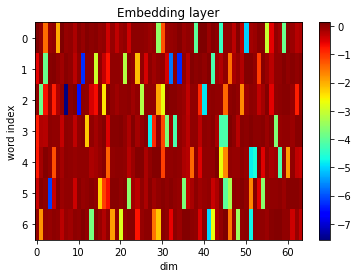

In [22]:
embed_wts = np.array(modules[3].weight.data)
plt.imshow(embed_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [23]:
attn = modules[6]

(64, 112)

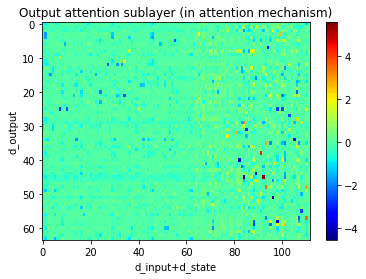

In [24]:
attn_wts = np.array(attn.attention.weight.data)
plt.imshow(attn_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state'); plt.ylabel('d_output')
plt.title('Output attention sublayer (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

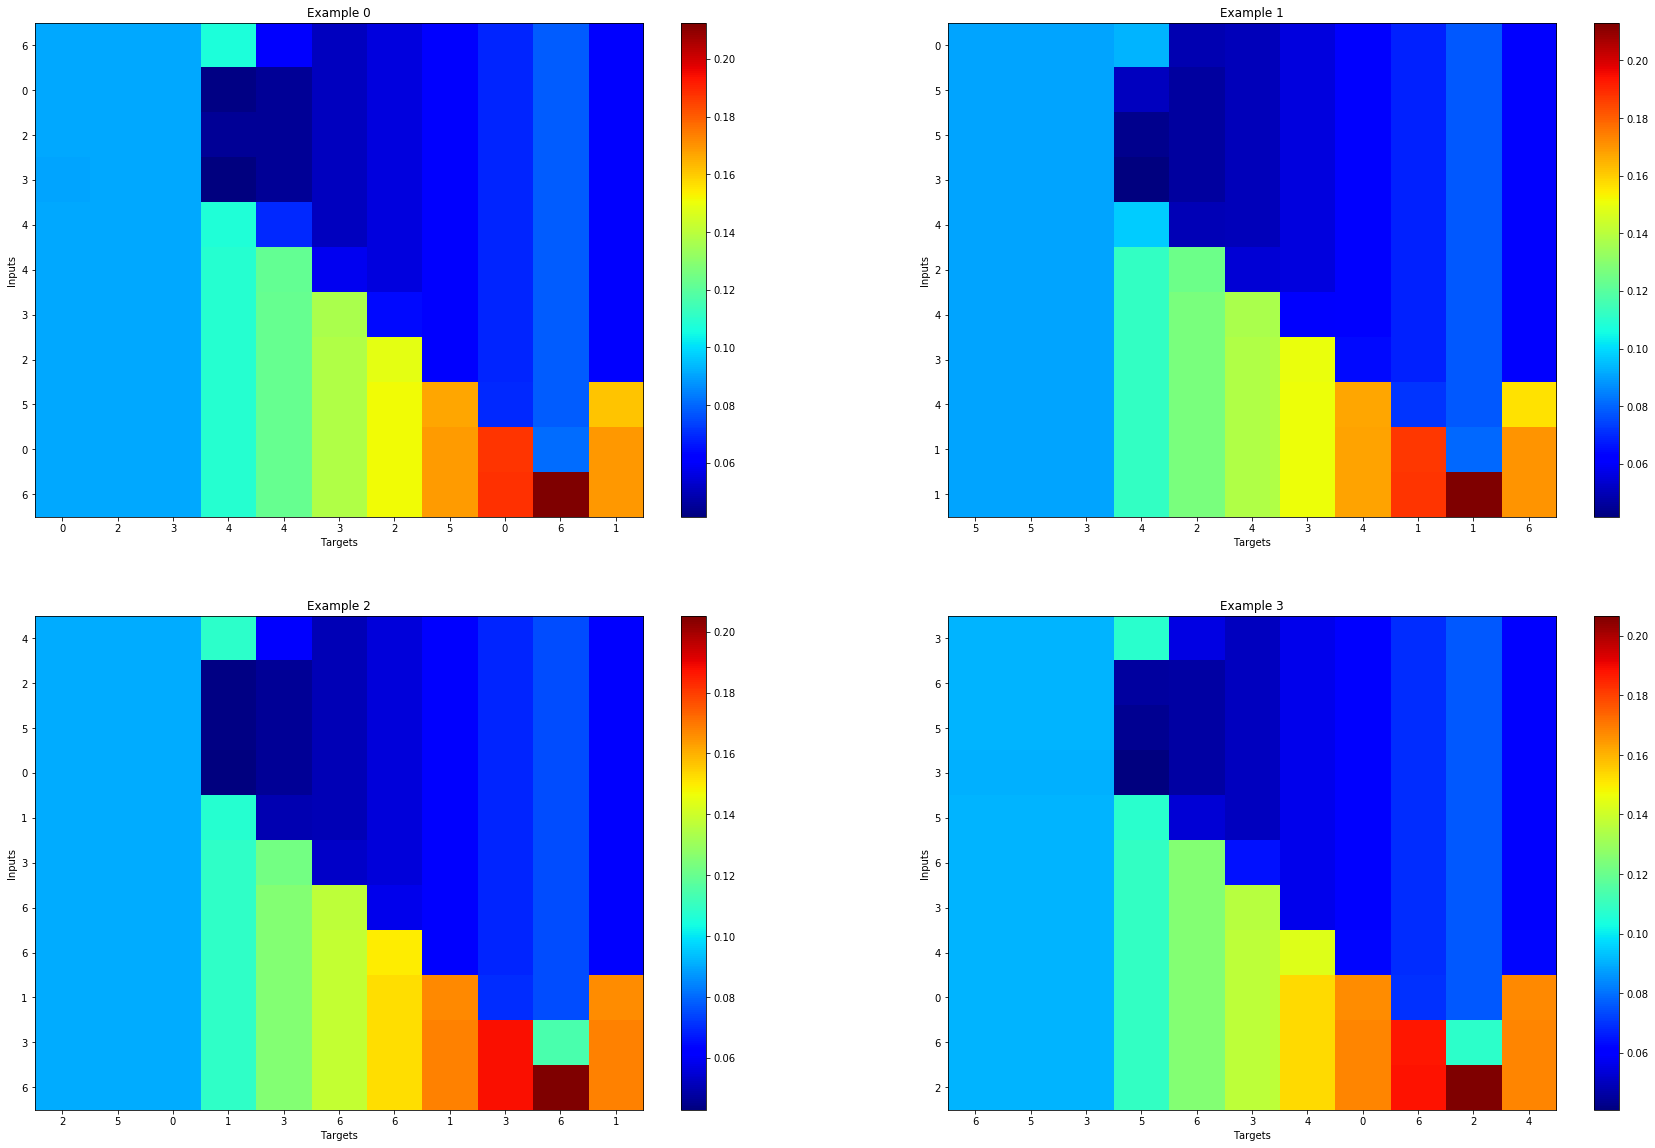

In [25]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()

The model output sequence is on the x-axis of each plot, with the weights summing to 1 along the y-axis, representing the input. 

The model seems to be considering all inputs in the sequence equally when making the first few predictions, but afterwards it only attends to the remaining items in the input sequence after each subsequent prediction is made; when predicting the second-to-last item, it even seems to most heavily consider only the last item in the input sequence. The exception is when the model attempts to predict the very last item in the sequence in which case it looks back at a few items right before; interestingly, the model incorrectly predicts this last item in each of these four examples.


At least for the predictions on the items in the middle of the target sequence, you can tell that the model is trying to make the prediction mostly based on the conditional probablity of seeing the remaining items in the input sequence, which is interesting because this toy dataset was generated by using a conditional distribution conditioned on some number of items appearing before each item.